# Ar Response Functions (W) Data Processing and Plotting

This notebook contains helper functions and plotting routines for processing data related to liquid Ar systems. It includes utilities for:
- Copying and loading simulation output files from remore cluster,
- Merging and analyzing binned data,
- Plotting results with custom styles.

Use this notebook to prepare and visualize data for further analysis or publication.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import subprocess
import numpy as np
plt.rcdefaults()
plt.rcParams
%matplotlib inline
plt.rcParams["figure.dpi"]=150
plt.rcParams["figure.facecolor"]="white"

SMALL_SIZE=14
Blue = '#0d73b2'
Red = '#d55b01'
Orange = '#de8f06'
Green = '#139e72'
Purple = '#cc78bc'
Brown = '#ca9160'
Light_blue = '#56b4e9'
Pink = '#fbafe4'
Gray = '#949494'
Yellow = '#ece132'
ibm_colors = ['#648FFF', '#FE6100', '#785EF0', '#DC267F', '#FFB000']
# work function in eV
# work_function = 9.2

In [2]:
# Function to execute the rsync command to copy files from remote
def copy_files_from_remote(remote_host, remote_folder, local_base_folder):
    # Define the rsync command to copy .dat and .in files recursively
    rsync_command = f"rsync -av --include='*/' --include='*.dat' --include='*.in' --exclude='*' {remote_host}:{remote_folder}/ {local_base_folder}/"
    
    # Run the command
    subprocess.run(rsync_command, shell=True, check=True)

# Function to load .dat files into numpy arrays
# TODO header might be more than one line, as in the refractive index case!
def load_dat_file(file_path):
    with open(file_path, 'r') as f:
                
        data = np.loadtxt(f)
        f.close()
    
    
    return data

# Function to save numpy arrays
def save_arrays(arrays, output_folder, subfolder_name):
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    
    for name, array in arrays.items():
        # Create a meaningful name based on the subfolder and array (column) name
        array_filename = f"{subfolder_name}_{name}.npy"
        array_path = os.path.join(output_folder, array_filename)
        
        # Save the numpy array
        np.save(array_path, array)
        print(f"Saved array: {array_path}")

In [3]:
def Erange(state):
    """
        :param state: orbital of xenon
        :return: the corresponding energy range assuming a work function of 9.2 eV
        these ranges are dependent and different for DFT liquid and RHF!!
        maybe, also different for DFT atom/solid...
        """
    
    # ranges chosen by looking at the DOS of the liquid!
    if state=='3p':
        return -15, 1
    if state=='3s':
        return -25, -15

In [4]:
def binmerge(v):
    """
        :param v: array of some binned quantity (like kG, momenta bin)
        :return: a array of half the length with bins merged!
        bins are merged only if the array has an even length!
        """
    if int(len(v)/2.0)==len(v)/2.0:
        x=np.zeros(int(len(v)/2.0))
        for i in range(len(x)):
            x[i]=(v[2*i]+v[2*i+1])/2.0
        return x
    else:
        return v

def grad(q,W):
    """
        :param q: 1D array on x axis
        :param W: 1D array on y axis
        :return: the same x array and the gradient (derivative) of the y array in a discrete fashion
        """
    rq=np.zeros(len(q)-1)
    rW=np.zeros(len(q)-1)
    for i in range(len(q)-1):
        rq[i]=(q[i]+q[i+1])/2.0
        rW[i]=(W[i+1]-W[i])/(q[i+1]-q[i])
    return rq,rW

In [5]:
def highest_occupied(W,E):
    """

        :param W: the form factor/response function (2D array)
        :param E: energy array, 1d
        :return: energy value of the highest occupied state (float). Is W always positive?
        """
    Emax=np.min(E)
    for iE in range(len(E)):
        if np.sum(W[:,iE])>0:
            Emax=E[iE]
    return Emax

def lowest_occupied(W,E):
    """

        :param W: the form factor/response function (2D array)
        :param E: energy array, 1d
        :return: energy value of the lowest occupied state (float). Is W always positive?
        """
    for iE in range(len(E)):
        if np.sum(W[:,iE])>0:
            return E[iE]


In [13]:
def plotfunc(my_ax, state, data_folder, derivative=0):

    """
       function for plotting Fig. X in the paper, momentum vs response function for one individual orbital
       params
       state: orbital is selected by parameter state
       """
    Emin,Emax=Erange(state)

    kgvec = np.loadtxt(data_folder + '/kG.dat') #Not convert to keV!
    Evec = np.loadtxt(data_folder + '/E.dat')
    W = np.loadtxt(data_folder + '/W.dat')
    W = np.reshape(W, (len(kgvec), len(Evec)))*2.0
    
    # set values at the last momentum bin = 0
    W[len(kgvec) - 1, :] = 0
    
    if data_folder=='DFT-atom':
        #W/=2.0
        W*=4.0
    elif data_folder=='DFT-liquid' or data_folder=='DFT-liquid-loopoverk-211000_fullecut' or data_folder=='../data/calculations-qedark-highest-thr-5.5/job_10':
        W/=60.0
    elif data_folder=='DFT-liquid-loopoverk-PZvsPBE_PAW_PBE' or data_folder=='DFT-liquid-loopoverk-PZvsPBE_PAW_PZ':
        W/=60.
    
    if data_folder == 'RHF':
        for iE in range(len(Evec)):
            # W[:, iE] *= 4 * np.pi * kgvec ** 2 / 1E6
            W[:, iE] *= 4 * np.pi * kgvec ** 2 / 1E12
            
    # set energy zero to the highest occupied DFT state
    Evec = Evec - highest_occupied(W, Evec)
    # these lines look as a some sort of "manual integral over energy" of the W
    # only one specific orbital is considered though! (one among 4d, 5s and 5p...)
    # this is how we separate these orbital contributions in our plots!!
    y=np.zeros(len(kgvec))
    for i in range(len(Evec)):
        
        # This line, as the function, is "orbital dependent"
        if Evec[i]>Emin and Evec[i]<Emax:
            y+=W[:,i]
    y*=Evec[1]-Evec[0]
    
    # specific normalization for RHF
    if state == '4d' and data_folder == '../../../einarsheritage/DOS_bestfit/RHF':
        y*=10.0/(np.sum(y)*(kgvec[1]-kgvec[0]))
    
    print(np.sum(y)*(kgvec[1]-kgvec[0])*1000)
    #if data_folder=='DFT-liquid':
    #    kgvec=binmerge(kgvec)
    #    y=binmerge(y)
    
    # take absolute value...
    if derivative==1 or derivative==2:
        kgvec,y=grad(binmerge(kgvec),binmerge(y))
        if derivative==2:
            kgvec,y=grad(kgvec,y)
        y=abs(y)
    
    my_ax.plot(kgvec/1000.0, y, label='curve')
    
    my_ax.set_yscale('log')
    my_ax.legend(loc='upper right', frameon=False, fontsize=10)  # Legend outside plot
    my_ax.set_xlim(3, 27)    
    #my_ax.set_title(title, fontsize=12, weight='bold')
    #my_ax.set_ylabel(y_ax_lable, size=12)    
    #my_ax.set_xlabel(x_ax_label,size=12)

In [10]:
# Define the connection and folder details
remote_host = "euler"
remote_folder = "/cluster/home/lmarin/cluster/scratch/lmarin/input_files_qedark_Ar_backup/calculations-qedark-highest-thr-5.5/"
local_base_folder = "../data/calculations-qedark-highest-thr-5.5/"
output_folder = "../data/numpy_arrays/calculations-qedark-highest-thr-5.5/"  # Folder to store saved numpy arrays

# Create local folder if not exists
os.makedirs(local_base_folder, exist_ok=True)

# Step 1: Copy files from remote server using rsync
copy_files_from_remote(remote_host, remote_folder, local_base_folder)

all_arrays = {}

# Step 2: Load .dat files and save numpy arrays by subfolder

# TODO update function for more than one .dat files! 
for root, dirs, files in os.walk(local_base_folder):
    for file in files:
        if file.endswith(".dat"):
            file_path = os.path.join(root, file)
            arrays = load_dat_file(file_path)
            

            # Get the subfolder name (relative to the base folder)
            subfolder_name = os.path.relpath(root, local_base_folder).replace(os.sep, "_")
            subfolder_name = subfolder_name + file
            print("subfolder name:", subfolder_name)

            # Save the numpy arrays, naming them by subfolder
            # save_arrays(arrays, output_folder, subfolder_name)
            all_arrays[subfolder_name] = arrays

receiving incremental file list
./
job_1/
job_1/E.dat
job_1/W.dat
job_1/dm.in
job_1/kG.dat
job_1/scf.in
job_10/
job_10/E.dat
job_10/W.dat
job_10/dm.in
job_10/kG.dat
job_10/scf.in
job_2/
job_2/E.dat
job_2/W.dat
job_2/dm.in
job_2/kG.dat
job_2/scf.in
job_3/
job_3/E.dat
job_3/W.dat
job_3/dm.in
job_3/kG.dat
job_3/scf.in
job_4/
job_4/dm.in
job_4/scf.in
job_5/
job_5/E.dat
job_5/W.dat
job_5/dm.in
job_5/kG.dat
job_5/scf.in
job_6/
job_6/E.dat
job_6/W.dat
job_6/dm.in
job_6/kG.dat
job_6/scf.in
job_7/
job_7/E.dat
job_7/W.dat
job_7/dm.in
job_7/kG.dat
job_7/scf.in
job_8/
job_8/E.dat
job_8/W.dat
job_8/dm.in
job_8/kG.dat
job_8/scf.in
job_9/
job_9/dm.in
job_9/scf.in

sent 20,155 bytes  received 15,283 bytes  14,175.20 bytes/sec
total size is 2,229,033  speedup is 62.90
subfolder name: job_10E.dat
subfolder name: job_10W.dat
subfolder name: job_10kG.dat
subfolder name: job_3E.dat
subfolder name: job_3W.dat
subfolder name: job_3kG.dat
subfolder name: job_6E.dat
subfolder name: job_6W.dat
subfolder name: j

In [11]:
len(all_arrays)

24

In [12]:
all_arrays['job_3W.dat']

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.21357368e-08, 1.45356060e-08, 1.05954844e-11])

1586.2556953290168
Number of lines in axes[0, 0]: 1
1586.2556953290168
Number of lines in axes[1, 0]: 1
1586.2556953290168
Number of lines in axes[2, 0]: 1
641.8727281874426
Number of lines in axes[0, 1]: 1
641.8727281874426
Number of lines in axes[1, 1]: 1
641.8727281874426
Number of lines in axes[2, 1]: 1


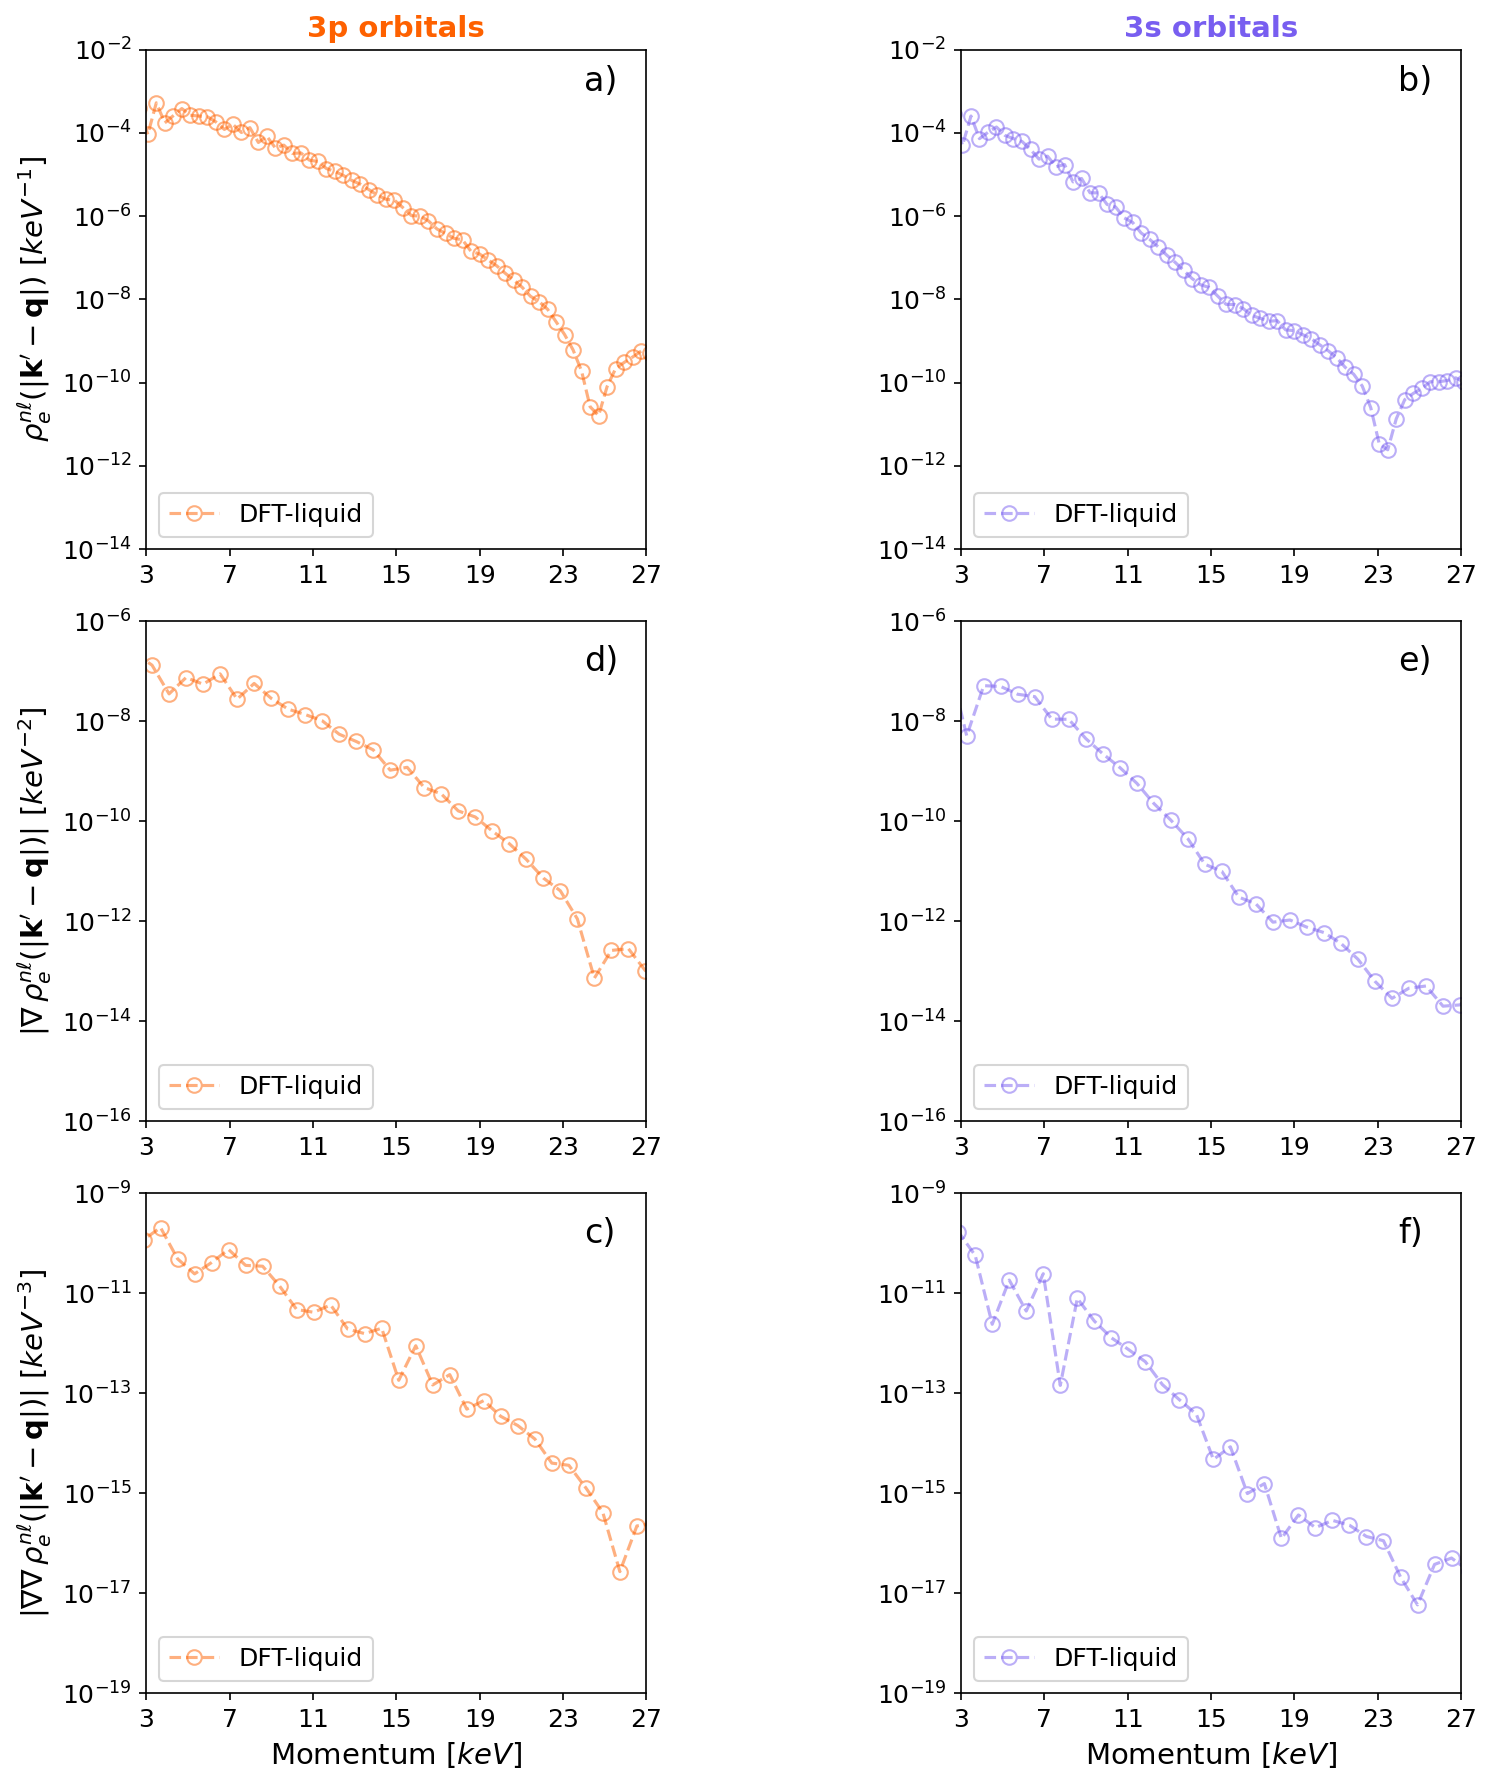

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Define custom styles for each plot
colors = ibm_colors[1:3]  # First dataset styles (Blue, Green, Red for different orbitals)
markers = ['o', 'D']  # Marker styles for the first dataset
linestyles = ['--', '--', '--']  # Linestyles for both datasets

letter=[['a)','b)','c)'],['d)','e)','f)']]

# Titles, labels, and other customization3
titles = [['3p orbitals', '3p orbitals', '3p orbitals'],
          ['3s orbitals', '3s orbitals', '3s orbitals']]

x_labels = r'Momentum $[keV]$'  # Same x-axis label for all plots
y_labels = [r'$\rho_e^{n \ell}(|\mathbf{k}^\prime-\mathbf{q}|)$ $[keV^{-1}$]', 
            r'$|\nabla\,\rho_e^{n \ell}(|\mathbf{k}^\prime-\mathbf{q}|)|$ $[keV^{-2}]$', 
            r'$|\nabla\nabla\, \rho_e^{n \ell}(|\mathbf{k}^\prime-\mathbf{q}|)|$ $[keV^{-3}]$']  # Different y-axis labels per row

derivative=[0, 1, 2]
orbital=['3p', '3s']
for i in range(len(orbital)):
    for j in range(len(derivative)):
        plotfunc(axes[j, i], orbital[i], '../data/calculations-qedark-highest-thr-5.5/job_10', derivative[j])
        print(f'Number of lines in axes[{j}, {i}]: {len(axes[j, i].lines)}')

        
        axes[j, i].lines[-1].set_color(colors[i]) 
        axes[j, i].lines[-1].set_alpha(0.5)
        axes[j, i].lines[-1].set_marker(markers[0])  # Set marker for the first curve
        axes[j, i].lines[-1].set_linestyle(linestyles[j])  # Set linestyle for the first curve
        axes[j, i].lines[-1].set_markersize(7)  # Set marker size
        axes[j, i].lines[-1].set_markerfacecolor('none')  # Set marker filling color
        # axes[j, i].lines[-1].set_markeredgecolor('blue')
        
        # Call plotfunc again for the second dataset (e.g., 'RHF')
#         plotfunc(axes[j, i], orbital[i], 'data/calculations-qedark-highest-thr-5.5/job_10', derivative[j])
#         print(f'Number of lines in axes[{j}, {i}]: {len(axes[j, i].lines)}')


#         # Customize the second curve appearance
#         axes[j, i].lines[-1].set_color(colors[i])  # Set different color for the second curve
#         axes[j, i].lines[-1].set_marker(markers[1])  # Set different marker for the second curve
#         axes[j, i].lines[-1].set_linestyle(linestyles[j])  # Set linestyle for the second curve
#         axes[j, i].lines[-1].set_markersize(7)  # Set marker size
#         axes[j, i].lines[-1].set_markerfacecolor('none')  # Set marker filling color
        # axes[j, i].lines[-1].set_markeredgecolor('blue')

        # Set titles, labels, and legends
        if j==0:
            axes[j, i].set_title(titles[i][j], fontsize=14, weight='bold', color=colors[i])
            axes[j, i].set_ylim(10**-14, 10**-2)
            axes[j, i].text(24, 10**-3, letter[j][i], size=16)

        
        if j==1:
            axes[j, i].set_ylim(10**-16, 10**-6)
            axes[j, i].text(24, 10**-7, letter[j][i], size=16)
        
        if j == 2:
            axes[j, i].set_xlabel(x_labels, fontsize=14)
            axes[j, i].set_ylim(10**-19, 10**-9)
            axes[j, i].text(24, 10**-10, letter[i][j], size=16)

        if i == 0:  # Set y-axis label only for the first column of each row
            axes[j, i].set_ylabel(y_labels[j], fontsize=14)

        # Custom legend for two curves
        axes[j, i].legend(
            ['DFT-liquid'],
            loc='lower left', fontsize=12)
        axes[j, i].set_xlim(3, 27)
        axes[j, i].xaxis.set_ticks(ticks=np.linspace(3, 27, 7))
        axes[j, i].tick_params(axis='x', labelsize=12)
        axes[j, i].tick_params(axis='y', labelsize=12)
        axes[j, i].set_box_aspect(1)



plt.tight_layout()
# plt.savefig('W_plot_paper_orbital.png')
# plt.savefig('W_plot_paper_orbital.pdf')
plt.show()